# Google Apps Exploration Data Analysis

I decided to do an Exploratory Data Analysis on Google Play Store Apps dataset from Kaggle. I was curious to find which variables correlated to the number of app installs, which categories and genres are the most downloaded and have the highest rating, and whether apps which have the highest rating and number of installs are updated more frequently. Let's start exploring!


In [243]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

In [262]:
# Download Datasets

apps = pd.read_csv('archive (1)/googleplaystore.csv')

# Data Preprocessing

## Data Inspection

In [256]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In total, there are 10,840 rows of data.

There are 13 variables, and only 'Reviews' variable is numeric. Looking at the data, we can see that 'Reviews', 'Size', 'Installs', and 'Price' can be converted into numeric variables. We'll do that in Feature Engineering part of this project.

In [257]:
apps.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


I don't think rating of 19 is allowed, since apps can only be rated 1 through 5. Let's see which app is rated at 19:/

In [263]:
apps[apps['Rating']==19]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


Looks like 'Category' is also mislabeled, and it doesn't have a 'Content Rating' value. Thus, I think we can drop this row of data

In [264]:
apps.drop(index=10472, axis=0, inplace=True)
apps.reset_index(drop=True, inplace=True)

In [265]:
apps.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

As you can see, there are 1474 empty values in 'Rating' column, and couple of missing values in other columns. We'll need to check whether those missing data is at random or is there an actual relationship (low level of app installs have no rating). We'll do this in Feature Engineering part of Data Cleaning.

## Data Cleaning

In [266]:
apps.duplicated(keep=False).sum()

893

There are 893 duplicates. It would be nice to get rid of them

In [267]:
apps.drop_duplicates(keep='first', inplace=True)

Upon a closer look, I found duplicates that have the same "App" name and "Category":

In [268]:
apps[apps.duplicated(keep=False, subset=['App', 'Category'])].sort_values(by='App').head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
3083,365Scores - Live Scores,SPORTS,4.6,666521,25M,"10,000,000+",Free,0,Everyone,Sports,"July 29, 2018",5.5.9,4.1 and up
5415,365Scores - Live Scores,SPORTS,4.6,666246,25M,"10,000,000+",Free,0,Everyone,Sports,"July 29, 2018",5.5.9,4.1 and up
1970,8 Ball Pool,GAME,4.5,14201604,52M,"100,000,000+",Free,0,Everyone,Sports,"July 31, 2018",4.0.0,4.0.3 and up
1755,8 Ball Pool,GAME,4.5,14200344,52M,"100,000,000+",Free,0,Everyone,Sports,"July 31, 2018",4.0.0,4.0.3 and up
1844,8 Ball Pool,GAME,4.5,14200550,52M,"100,000,000+",Free,0,Everyone,Sports,"July 31, 2018",4.0.0,4.0.3 and up


These duplicates are different in the number of 'Reviews' each app has. For accurate statistical anaylisis, I'll only keep one of these duplicates.

In [269]:
apps.drop_duplicates(keep='first', subset=['App', 'Category'], inplace=True)

I'll also drop 'Android Ver' and 'Current Ver' variables since they are not relevant in my research.

In [270]:
apps.drop(['Current Ver', 'Android Ver'], axis=1, inplace=True)

## Feature Engineering

### Converting strings to numeric variables

In [272]:
apps['Reviews'] = pd.to_numeric(apps['Reviews'])


'Size' variable indicates the size of an app either in Megabytes (M) or in Kilobytes (k). There are also apps that have different sizes depending on the device, and have size label of "Varies with device". I want to create a numerical column that records the size of an app in kilobytes 

In [273]:
def convert_size_to_num(value):
    if 'M' in value.upper():
        return float(value.split('M')[0]) *1000
    elif 'k' in value:
        return float(value.split('k')[0])
    else:
        return None

In [274]:
apps['Size_kilobytes'] = apps['Size'].apply(convert_size_to_num)

In [275]:
def convert_Price_to_numeric(value):
    if len(value) > 1:
        num = float(value.split('$')[1])
    else:
        num = float(value)
    return num

In [279]:
apps['Price_$'] = apps['Price'].apply(convert_Price_to_numeric)

Let's convert 'Installs' feature to numeric integers

In [280]:
def convert_installs_to_num(value):
    arr = value.strip('+').split(',')
    return int(''.join(arr))

In [281]:
apps['installs_num'] = apps.Installs.apply(convert_installs_to_num)

Also, we can get the number of genres an app has:

In [282]:
def get_genre_num(value):
    genre_num = int(len(value.split(';')))
    return genre_num
    
apps['genre_num'] = apps['Genres'].apply(get_genre_num)

### Dealing with missing values

As we saw before, there are 1474 missing values in 'Rating' column. Since I'll be using this feature to see how it affects the number of installs I can't just drop the values without seeing whether there is some correlation between empty 'Rating' values and other features like 'Installs' number and number of 'Reviews'. Let's explore it to see whether we should drop the value or impute it.

In [283]:
na_rating_df = apps[apps['Rating'].isna()]

In [284]:
na_rating_df['Reviews'] = na_rating_df['Reviews'].astype(float)

/var/folders/h2/b13_qgn11pj7643wk_7fh_rw0000gn/T/ipykernel_89035/3730960679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_rating_df['Reviews'] = na_rating_df['Reviews'].astype(float)


In [285]:
na_rating_df = na_rating_df[['Category', 'Type', 'Content Rating', 'Reviews', 'Genres', 'Size_kilobytes',
       'Price_$', 'installs_num']]

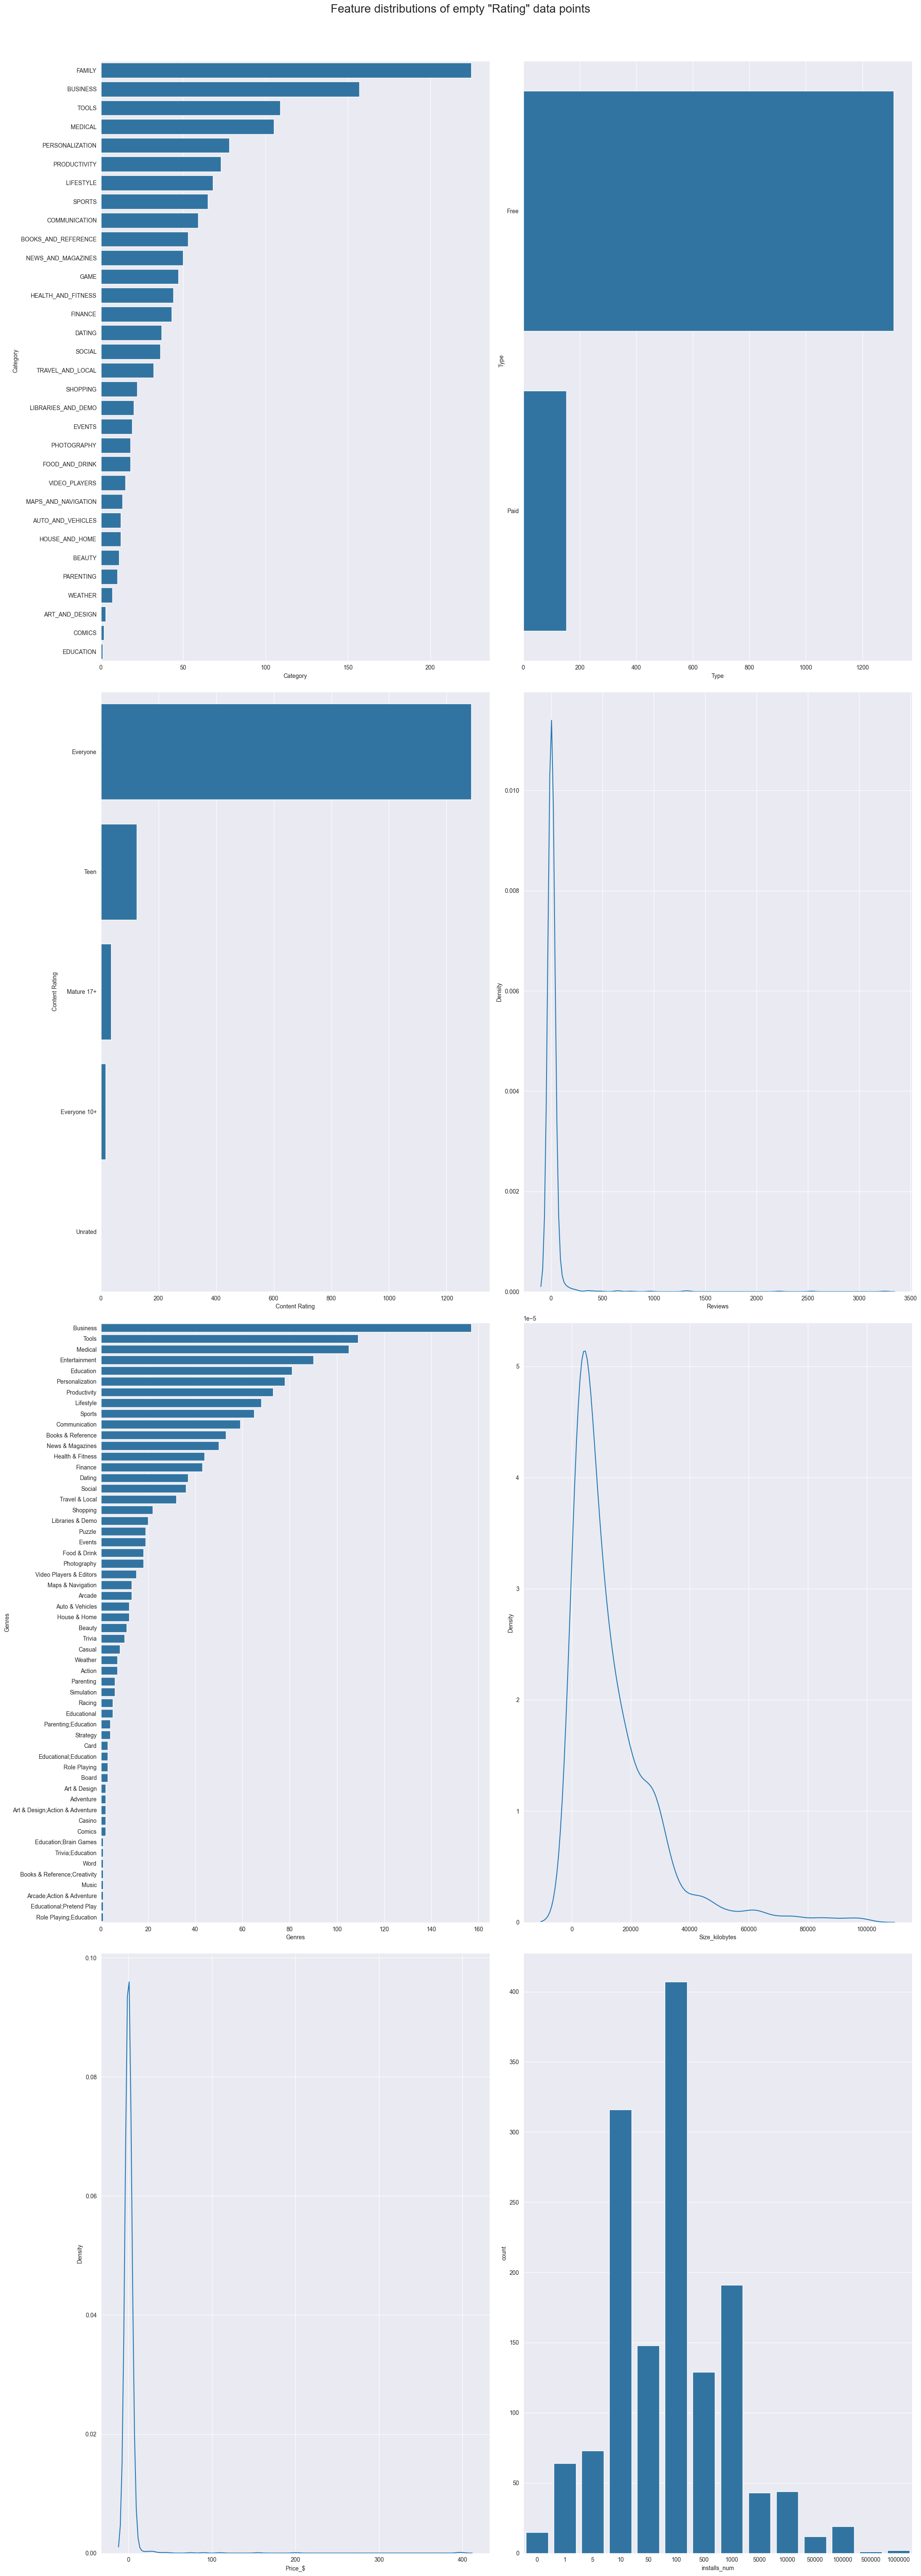

In [286]:
_, axs = plt.subplots(4, 2, figsize=(22, 60))
for col, ax in zip(na_rating_df.columns, axs.ravel()):
    if na_rating_df[col].dtype == float:
        sns.kdeplot(data=na_rating_df, x=col, ax=ax,)
    elif na_rating_df[col].dtype == int:
        sns.countplot(data=na_rating_df, x=col, ax=ax)
    else:
        sns.countplot(y=na_rating_df[col], ax=ax, order=na_rating_df[col].value_counts().index)
    # else: #int
    #     vc = train[col].value_counts()
    #     ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions of empty "Rating" data points', y=1.02, fontsize=20)
plt.show()

Characteristics of empty Rating value apps:

- Mostly are in 'Family' and 'Business' Category
- Majority of apps are 'Free'
- Majority Content rating is for 'Everyone'
- Most of the data has 0 Reviews
- Majority of apps are in 'Business', 'Tools' and 'Medical' genres
- Most of the apps are less than 20 Megabytes in Size
- Majority of apps have price of $0
- Majority of apps has about 100 installs

We can see that unrated apps mostly are free, have no reviews, small number of installs, and are relatively low in size. If the proportion of missing values was low, random, or wasn't important for analysis, then it would be justifiable to drop NA values. As you can see, unrated apps are about 10% of our data (which is substantial), are not random (unrated apps have low number of installs and no reviews) and 'Rating' feature is important for our analysis. Thus, it would be better if we impute the values with the median value in the 'Rating' column

In [287]:
# get the median value
median_value = apps['Rating'].median()

# Impute the missing values in the 'Rating' column with the calculated median value
apps['Rating'].fillna(value=median_value, inplace=True)

# Initial Data Analysis

<Figure size 2000x3000 with 0 Axes>

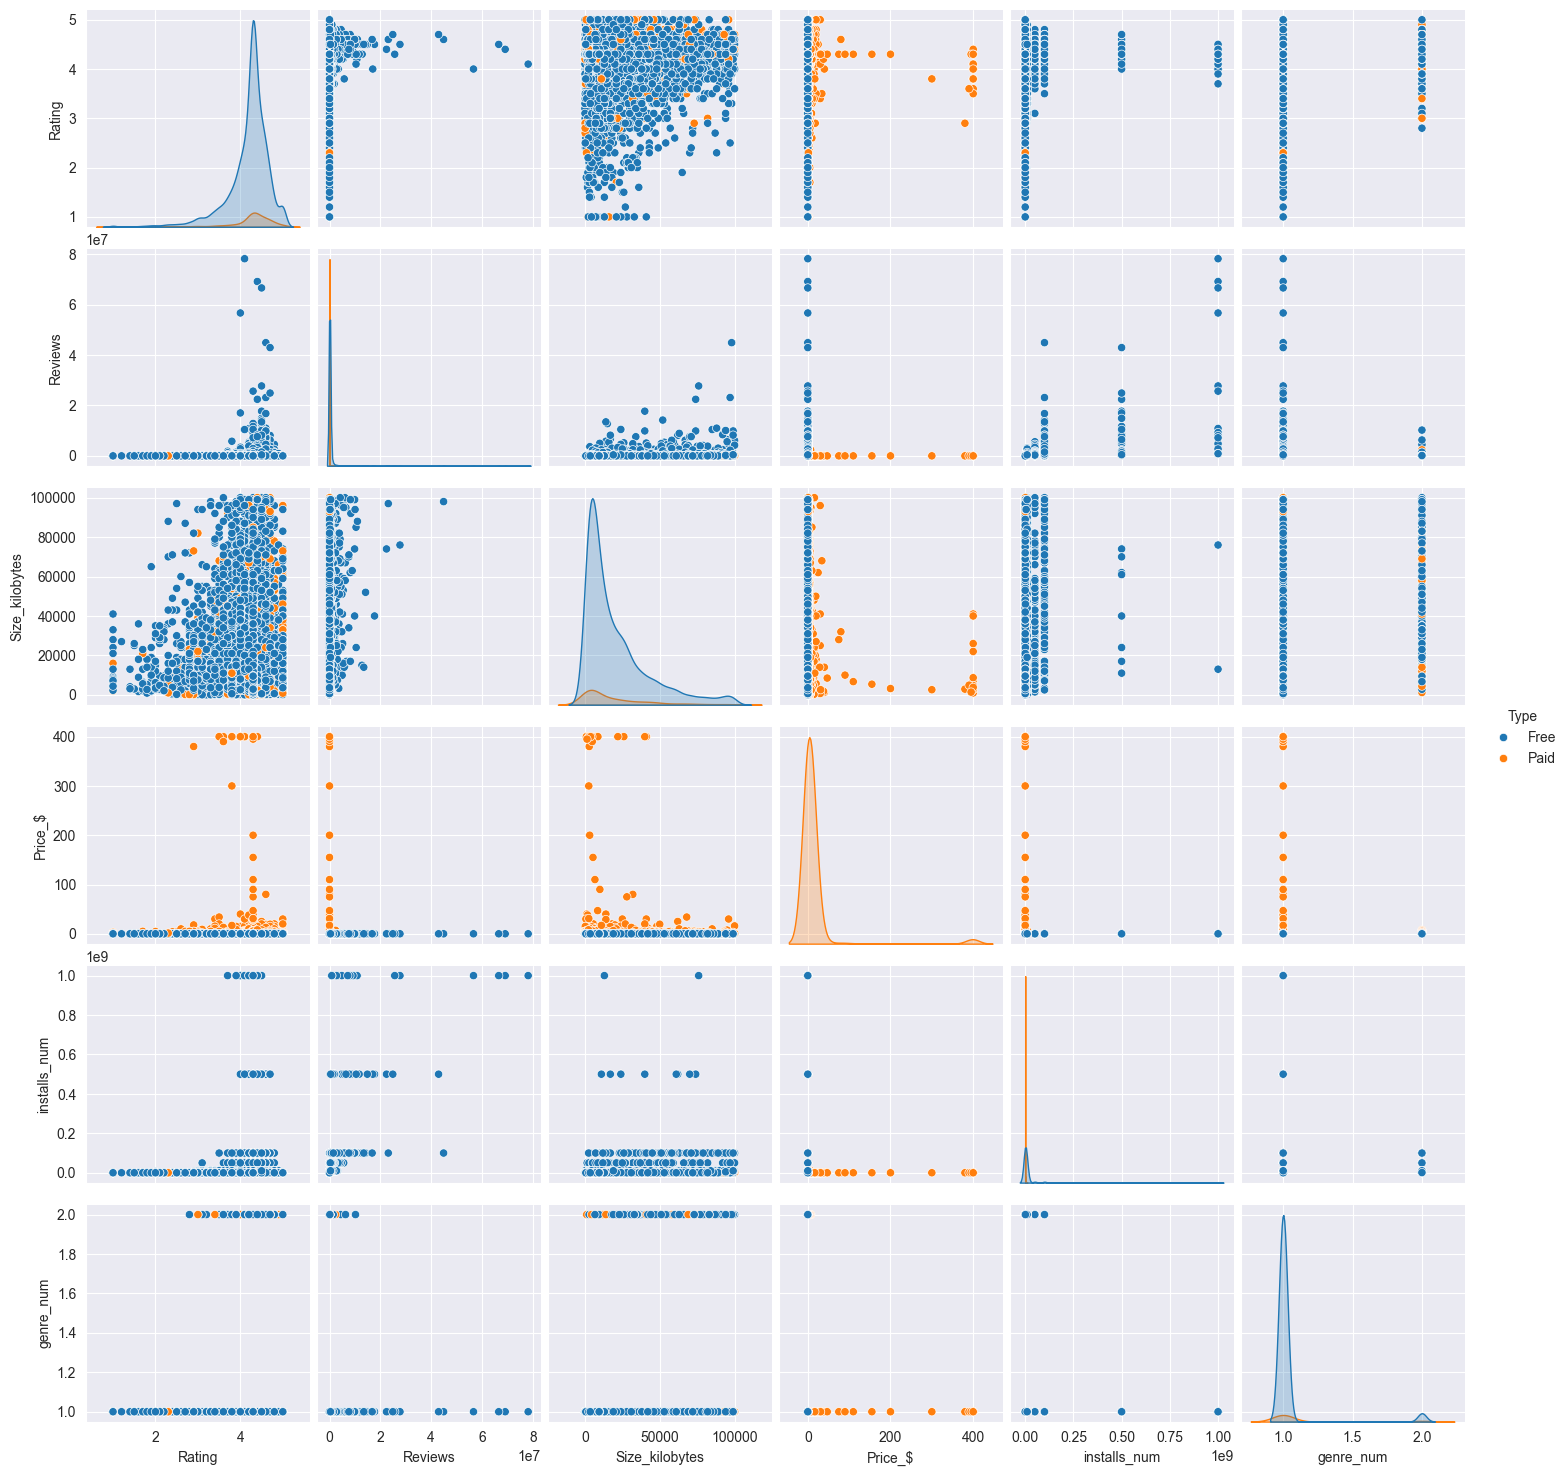

In [288]:
plt.figure(figsize=(20,30))
sns.pairplot(data=apps, hue='Type')

1) **Installs & Rating**
    - A lot of data distribution in rating that have low number of installs, indicating that a large number of apps have fewer installations  regardless of their rating.
    - Apps with high installation number have a higher rating compared to apps with low installation number, suggesting that a high rated app may be installed more than a low rated one.
    - Interesting to see how there no high installed apps in the lower rating part of the graph. This could be explained that high installed apps get updated more frequently due to a high amount of use and feedback from their users.
<br/>
<br/>

2) **Installs & Reviews**
   - low number of installed apps tend to have a low number of reviews.
   - high distribution in the number of reviews of high installed apps, suggesting that having high reviews doesn't determine whether an app will have a high number of installations
   - Although, apps with the highest number of reviews have a high number of installations.  
<br/>
<br/>

3) **Installs & Size**
   - no clear relationship or trend, suggesting that 'Size' of an app doesn't play a pivotal role in determing the number of installations
<br/>
<br/>

4) **Installs & Price**
    - All paid apps have a low installation number. It would be interesting to seperate paid apps and see their distribution of installs.
<br/>
<br/>
  
5) **Installs & Number of Genres**
   - highly installed apps belong only to one genre

In [289]:
sns.set_style('white')

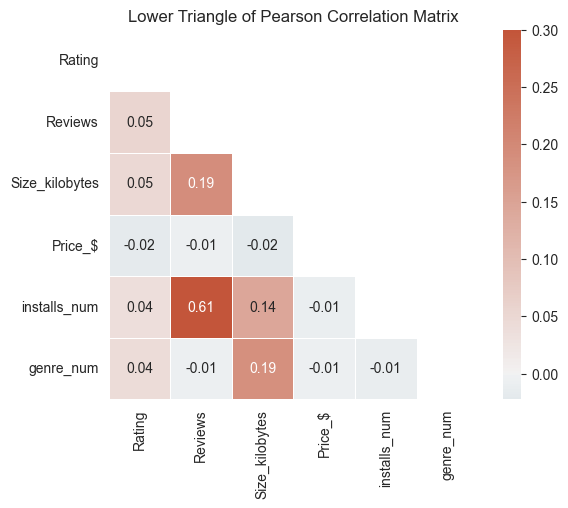

In [290]:
# Calculate the correlation matrix
numeric_df = apps.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr(method='pearson')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, 
            vmax=.3, center=0, square=True, 
            linewidths=.5, annot=True, fmt='.2f', )

plt.title('Lower Triangle of Pearson Correlation Matrix')
plt.show()

Number of reviews has the highest correlation to the number of installs. 

In [291]:
sns.set_style('darkgrid')

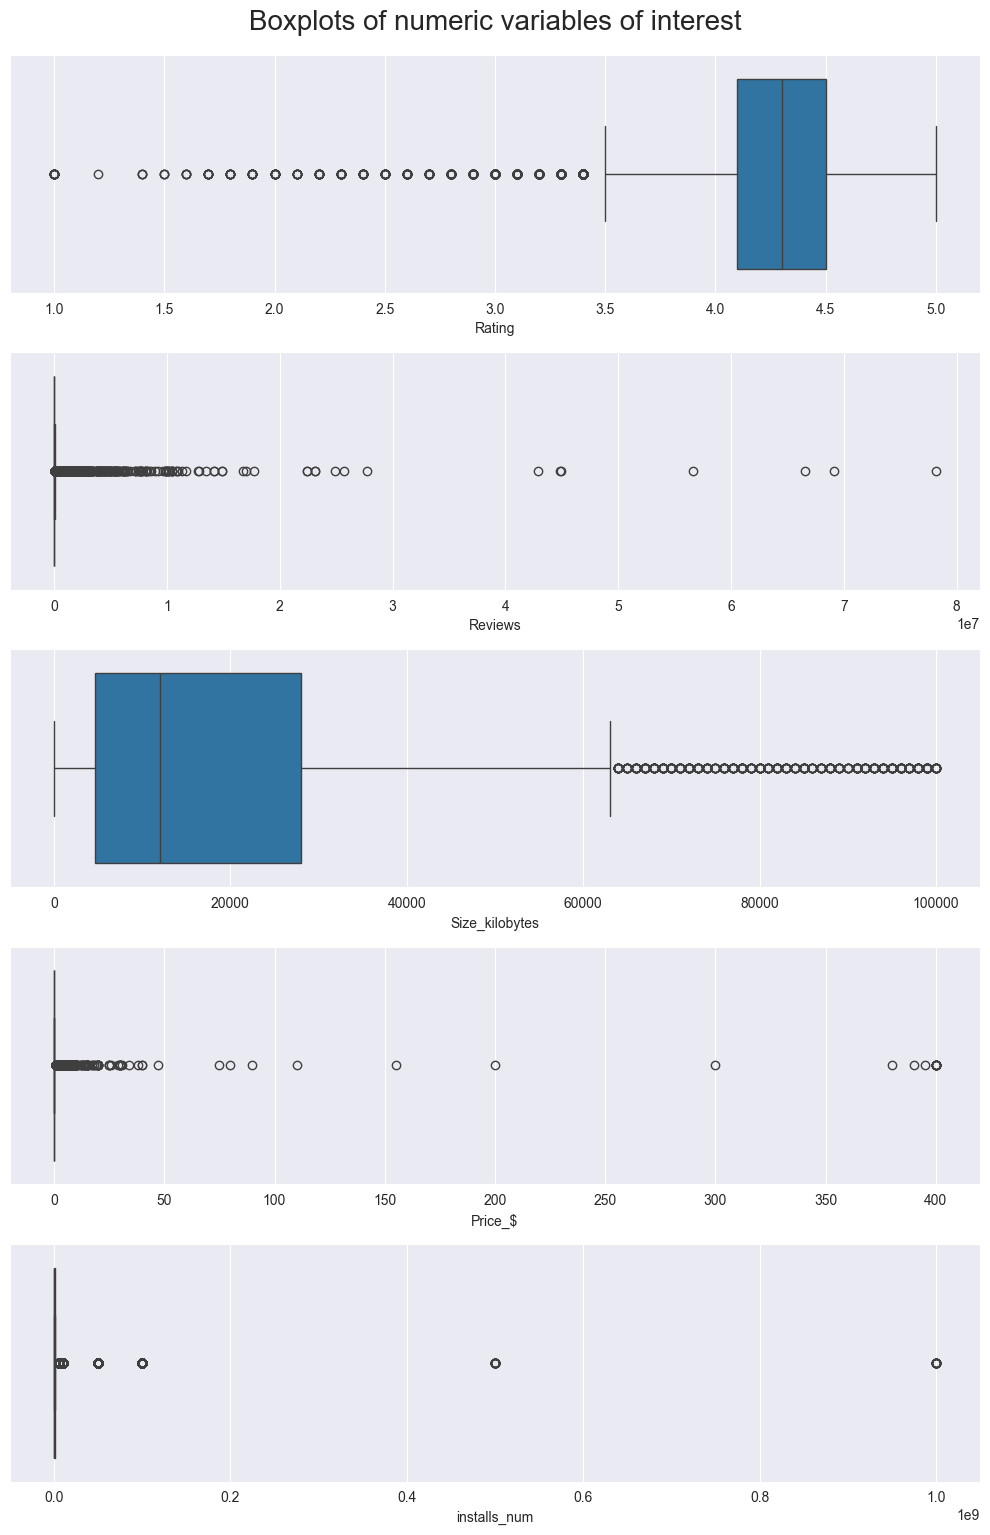

In [292]:
_, axs = plt.subplots(5, 1, figsize=(10, 15))
for col, ax in zip(apps.select_dtypes(include=np.number).columns[:-1], axs.ravel()):
    if apps[col].dtype == float:
        sns.boxplot(data=apps, x=col, ax=ax,)
    elif apps[col].dtype == int:
        sns.boxplot(data=apps, x=col, ax=ax)
    # else: #int
    #     vc = train[col].value_counts()
    #     ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Boxplots of numeric variables of interest', y=1.02, fontsize=20)
plt.show()

There are outliers in every numerical variables except 'genre_num' since it only has two values (1 and 2).

Variables 'Reviews', 'Price_$' have the highest number of outliers. Variable 'install_num' in comparison doesn't have as much outliers, but there is quite a big gap between the number of installs.

Since this is mostly an EDA project, I won't remove or deal with outliers. Although, it would make sense to truncate and transform some variables, if I were to create a model to predict the number of app installations. Also, it would make sense to seperate apps with the highest number of installations and do a separate analysis.

<br/><br/>

Let's see how many apps have the highest number of installs:


In [293]:
apps.groupby('installs_num', as_index=False)['App'].count().sort_values(by='installs_num', ascending=False).head(3)

,installs_num,App
19,1000000000,21
18,500000000,27
17,100000000,204


As we can see, there are 21 apps that have more than a billion installs. It would be interesting to seperately explore high installed apps, and see how they are different from each other. Here's the list of apps with the highest installations:

In [294]:
apps[apps['installs_num']== 1000000000]['App'].reset_index(drop=True)

0                            Google Play Books
1     Messenger – Text and Video Chat for Free
2                           WhatsApp Messenger
3                 Google Chrome: Fast & Secure
4                                        Gmail
5                                     Hangouts
6                Skype - free IM & video calls
7                            Google Play Games
8                               Subway Surfers
9                                     Facebook
10                                   Instagram
11                                     Google+
12                               Google Photos
13                   Maps - Navigate & Explore
14                          Google Street View
15                                      Google
16                                Google Drive
17                                     YouTube
18                     Google Play Movies & TV
19                                 Google News
20                           Google Play Games
Name: App, dt

# Visual Exploratory Analysis

## How do app ratings vary between free and paid apps?

Text(8, 0.6, 'Median Rating of Paid Apps: 4.30')

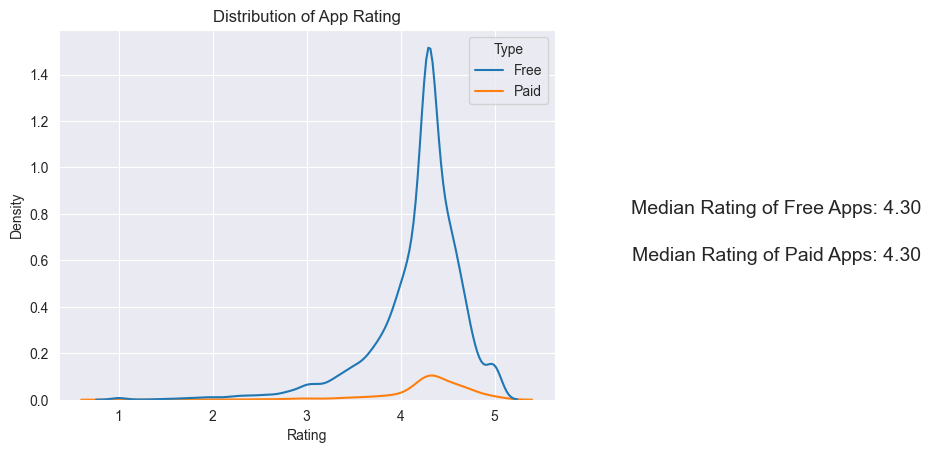

In [295]:
sns.kdeplot(data=apps, x='Rating', hue='Type')
plt.title('Distribution of App Rating')
plt.text(8, 0.8, 'Median Rating of Free Apps: {:.2f}'.format(apps[apps['Type']=='Free']['Rating'].median()), fontsize=14, fontfamily='sans-serif', ha='center')
plt.text(8, 0.6, 'Median Rating of Paid Apps: {:.2f}'.format(apps[apps['Type']=='Paid']['Rating'].median()), fontsize=14, fontfamily='sans-serif',  ha='center')

Interesting to see that the median of app rating for both types is the same!

## Which categories have the most number of apps?


/var/folders/h2/b13_qgn11pj7643wk_7fh_rw0000gn/T/ipykernel_89035/3003280729.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=apps, y='Category', order=apps.Category.value_counts().index, palette='viridis')


Text(0.5, 1.0, 'Count of Apps per Category')

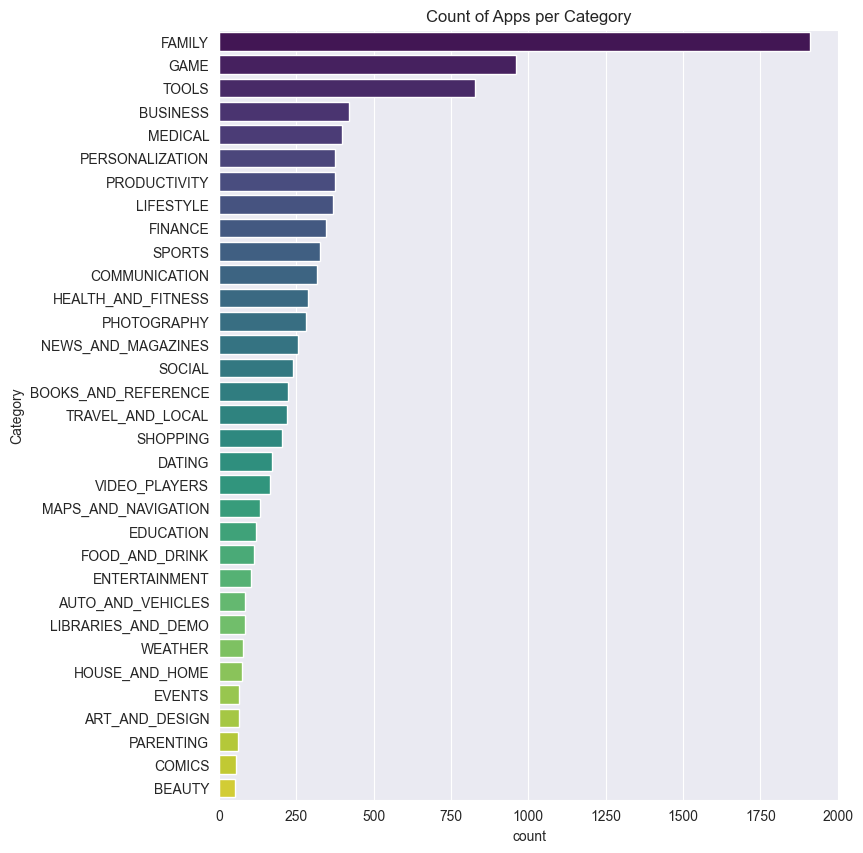

In [296]:
plt.figure(figsize=(8,10))
sns.countplot(data=apps, y='Category', order=apps.Category.value_counts().index, palette='viridis')
plt.title('Count of Apps per Category' )

'Family' category has the highest number of apps.

#### Let's see the distribution of every numerical variable with the Category of an app

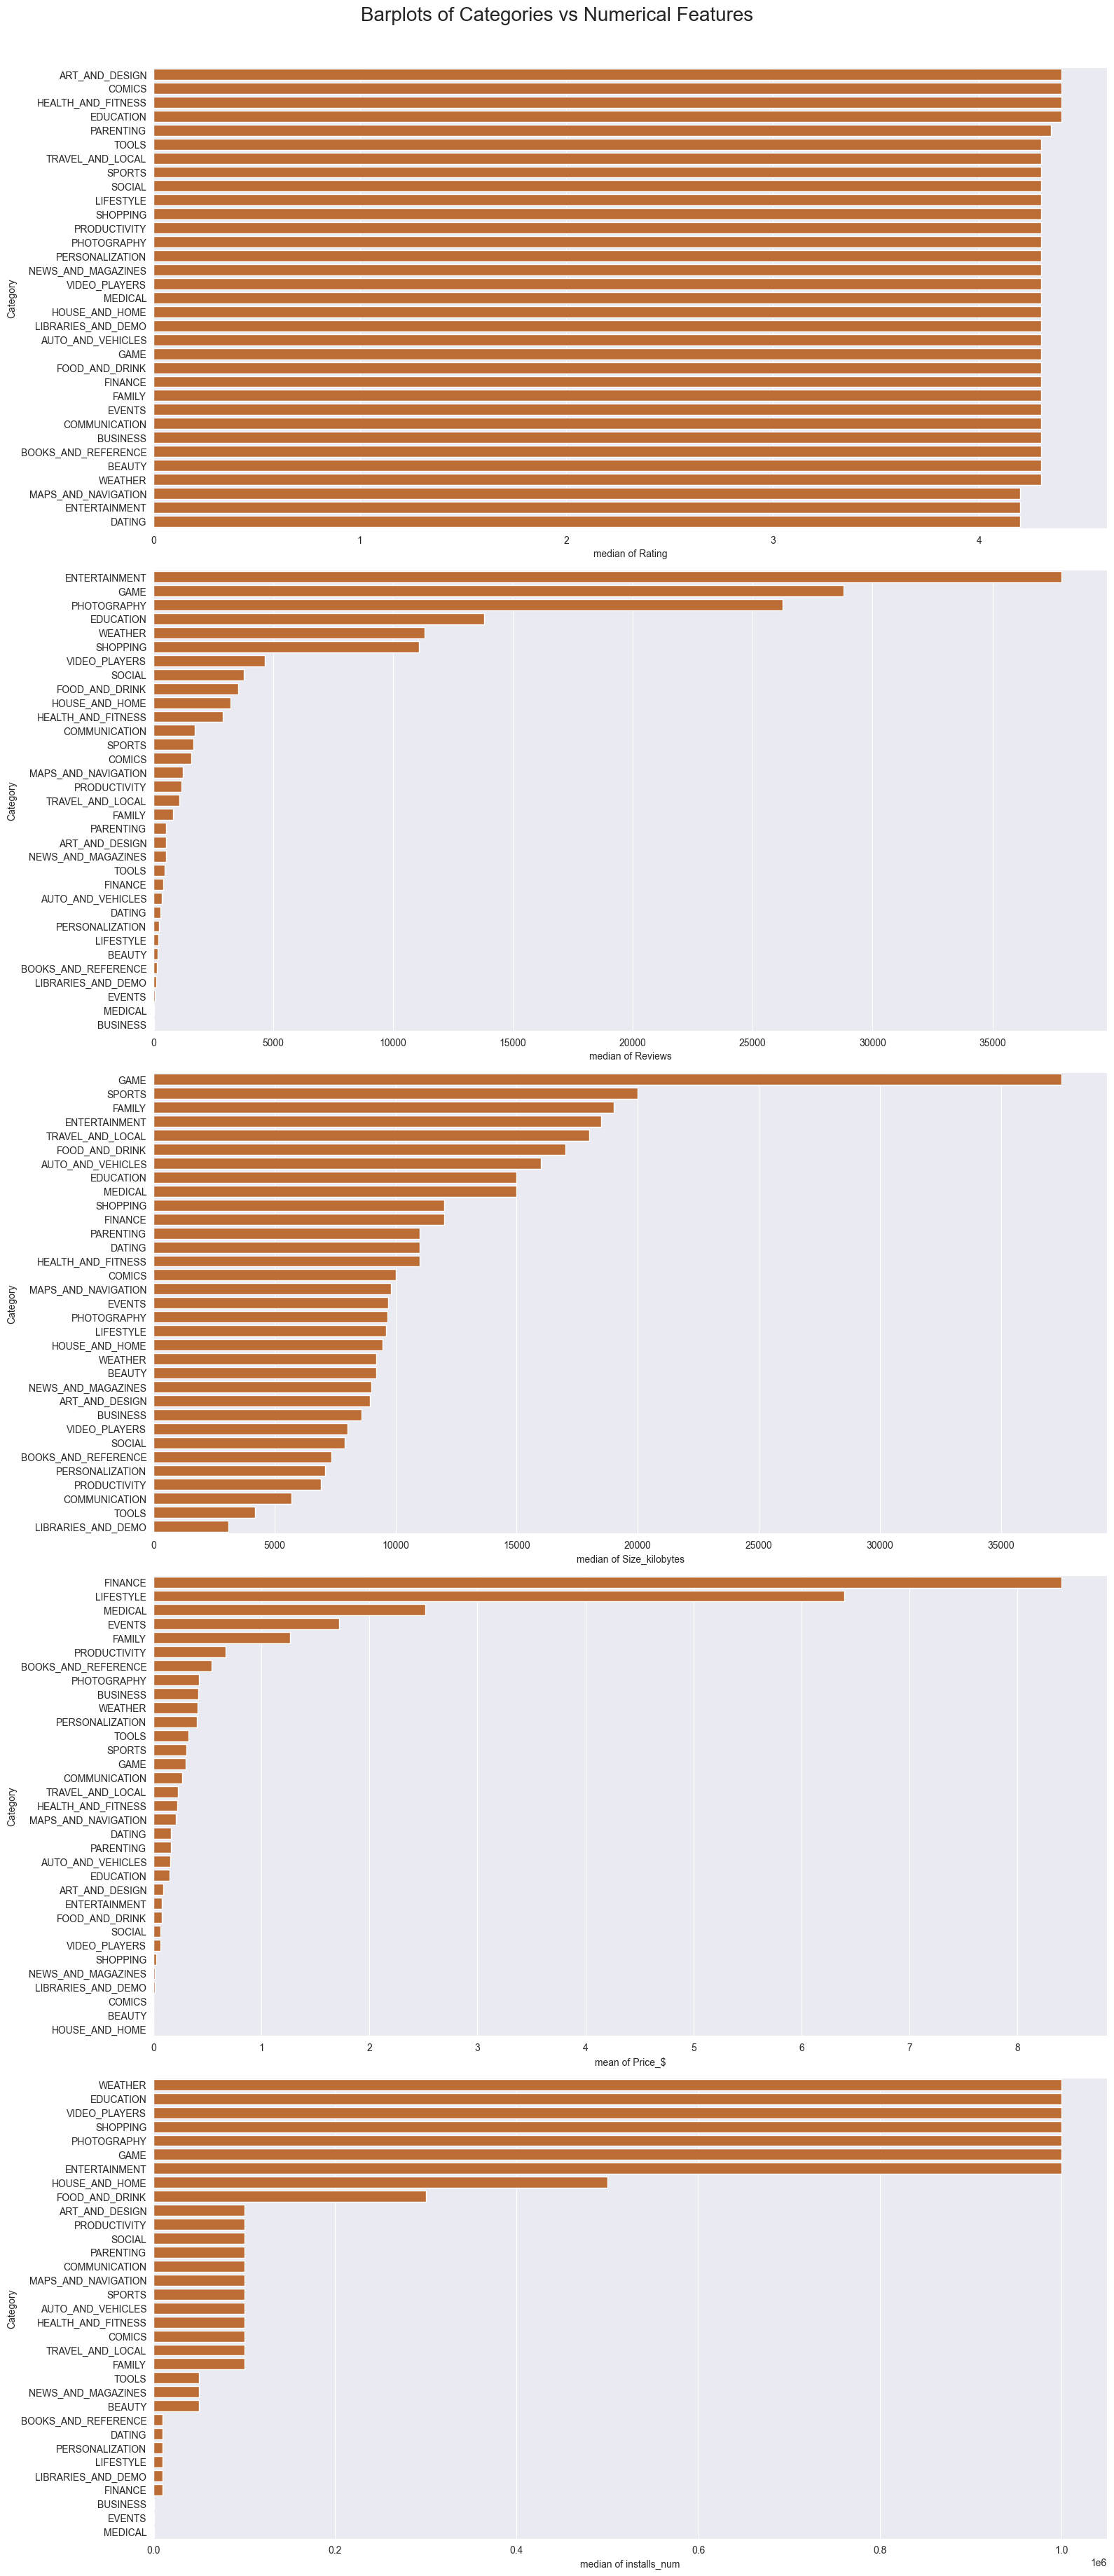

In [297]:
cat_group1 = apps.groupby('Category', as_index=False).agg({
                                                        'Rating' : 'median',
                                                        'Reviews': 'median',
                                                         'Size_kilobytes': 'median',
                                                         'Price_$': 'mean',
                                                         'installs_num': 'median'}) 

_, axs = plt.subplots(5, 1, figsize=(16, 36))
for col, ax in zip(cat_group1.columns[1:], axs.ravel()):
    if cat_group1[col].dtype == float:
        sns.barplot(y=cat_group1['Category'], x = cat_group1[col], color='chocolate', ax=ax, 
                    order=cat_group1.sort_values(by=[col], ascending=False)['Category'])
    elif cat_group1[col].dtype == int:
        sns.barplot(y=cat_group1['Category'], x = cat_group1[col], color='chocolate', ax=ax, 
                order=cat_group1.sort_values(by=[col], ascending=False)['Category'])
    # else: #int
    #     vc = train[col].value_counts()
    #     ax.bar(vc.index, vc, color='chocolate')
    if col != 'Price_$':
        ax.set_xlabel('median of '+col)
    else:
        ax.set_xlabel('mean of '+col)
        
plt.tight_layout()
plt.suptitle('Barplots of Categories vs Numerical Features', y=1.02, fontsize=20)
plt.show()


### Summary of the plot above

**Categories with the highest Median Rating**
- Art and Design
- Comics
- Health and Fitness
- Education


**Category with the highest median number of reviews**
- Entertainment


**Category with the highest median size of an app**
- Game


**Category with the highest mean price for an app**
- Finance


**Categories with the highest median installations**
- Weather
- Education
- Video players
- Shopping
- Photography
- Game
- Entertainment


Note that I mostly used medians, because most of the variables are highly skewed.


Apps in category 'Game' have the highest average size in kilobytes.

## How many apps have multiple genres? What are some of the most common combinations?


In [298]:
print('Number of apps with 2 genres is '+str(len(apps[apps['genre_num']==2])))

Number of apps with 2 genres is 421


Text(0.5, 1.0, 'Count of genre combinations')

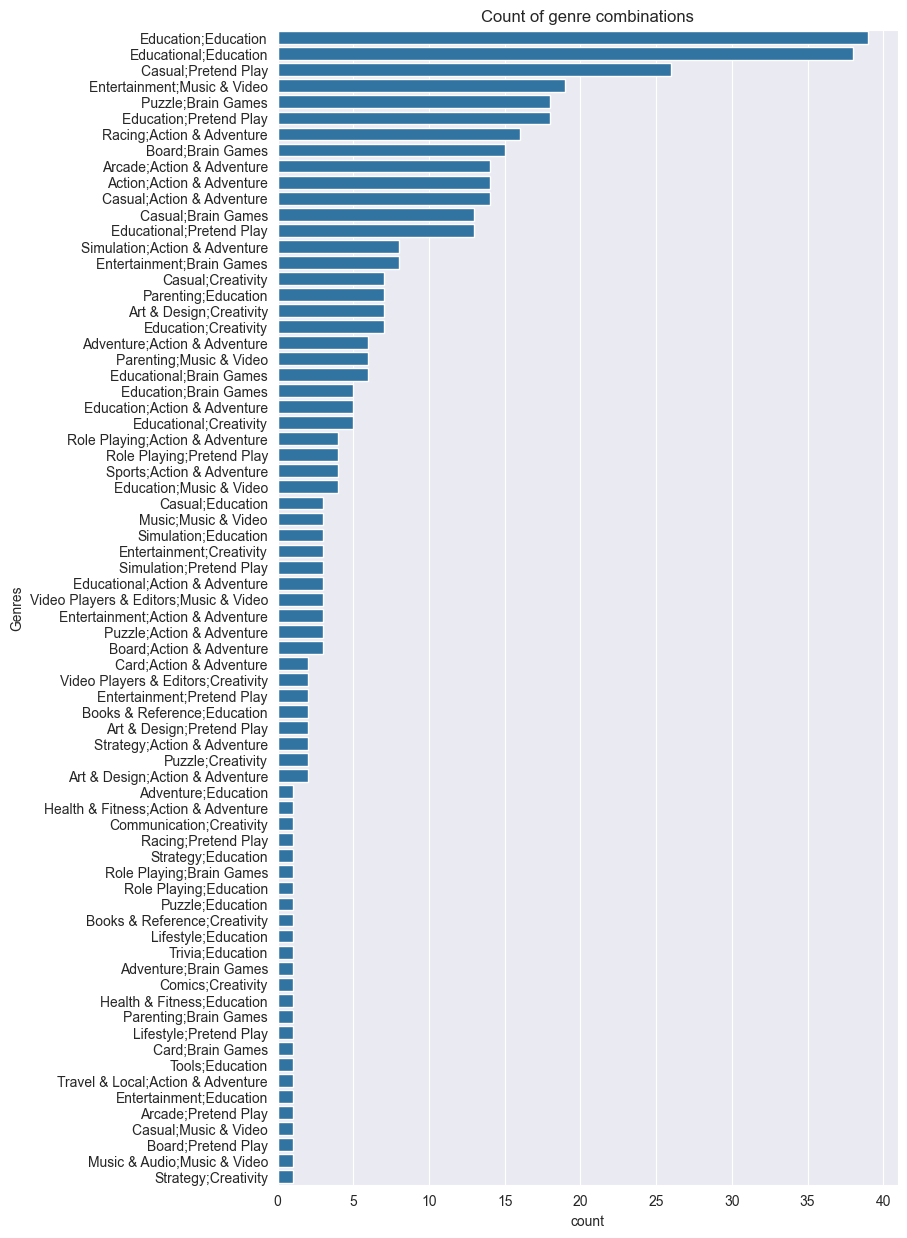

In [299]:
multiple_genre_df = apps[apps['genre_num']==2]

plt.figure(figsize=(8,15))
sns.countplot(data=multiple_genre_df, y='Genres', order=multiple_genre_df['Genres'].value_counts().index)
plt.title('Count of genre combinations')

So, the most common genre combination is 'Education:Education', which is a bit excessive...Most of these apps are language apps

## Do higher-rated apps have the most frequent update?

Text(0.5, 1.0, 'Rating vs Last Update of an app')

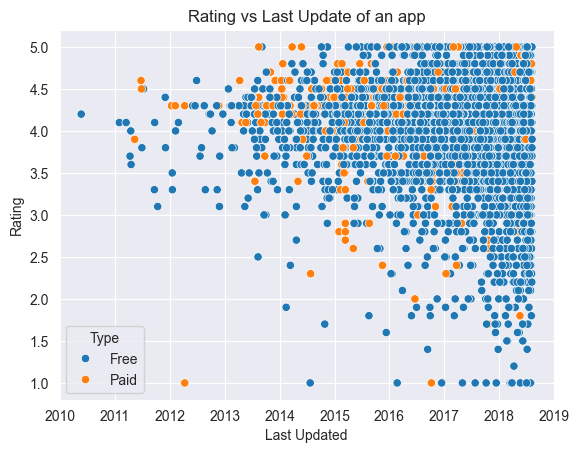

In [300]:
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])

sns.scatterplot(data=apps, x='Last Updated', y='Rating', hue='Type' )
plt.title('Rating vs Last Update of an app')

From the plot above we can see that in general there is no clear relationship between the last updates and the rating of an app. There is a big range of distributions of apps that had the most frequent update. One thing we can see is an increasing trend of development through out the years.

## How do the app ratings differ across different content ratings (Everyone, Teen, Mature, etc.)?

Text(0.5, 1.0, 'Number of apps per Content Rating')

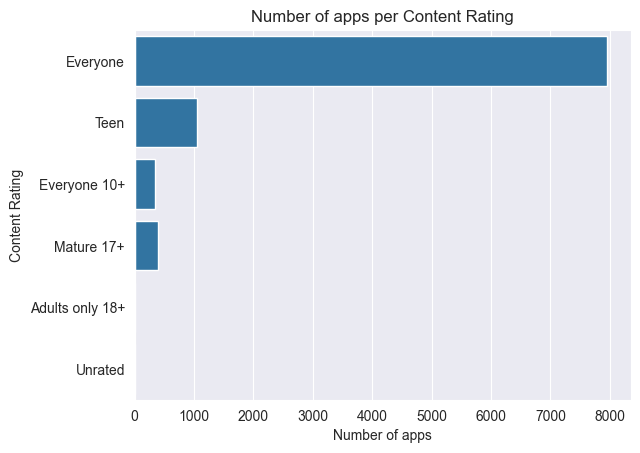

In [301]:
sns.countplot(data=apps, y='Content Rating')
plt.xlabel('Number of apps')
plt.title('Number of apps per Content Rating')

Majority of apps fall under 'Everyone' content rating

Text(0.5, 1.0, 'Rating of different content types')

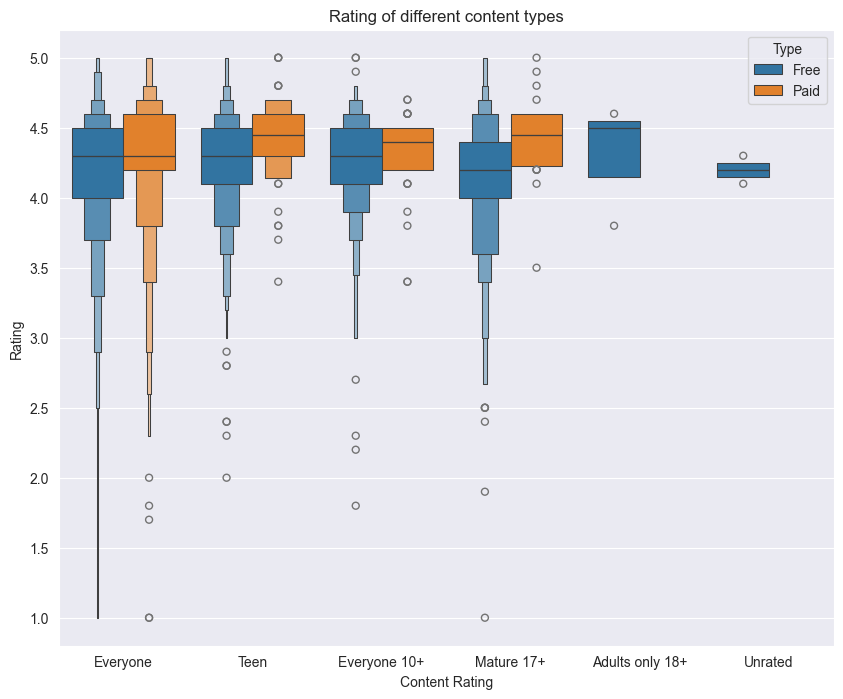

In [302]:
plt.figure(figsize=(10,8))
sns.boxenplot(data=apps, x='Content Rating', y='Rating', hue='Type')
plt.title('Rating of different content types')

Interestingly, 'Adults only 18+' content has the highest average rating among all of the content rating and app types.

# Summary and Conclusion

## Correlations and Relationships

Apps with more reviews tend to have more installs, indicating that user feedback is important for an app's success. Higher-rated apps usually have more installs, which shows that quality and user satisfaction are key to an app's success. Conversely, apps with lower ratings tend to have fewer installs, which means that user feedback and regular updates can help boost usage. The size of an app doesn't have much effect on its popularity. Paid apps are typically installed less often than free apps, although more investigation is needed to understand how paid apps perform.

## Numerical Insights

Most numerical variables have outliers, with 'Reviews' and 'Price_$' having the most significant deviations. For purposes of modeling or predictive analysis, handling these outliers will be essential, but within the context of EDA, they offer valuable perspectives on the distribution and variability of the dataset.


## Category Analysis:

**Ratings**

- 'Art and Design', 'Comics', 'Health and Fitness', and 'Education' are the categories with the highest median ratings, indicating that users find these categories particularly satisfying. 

**Reviews**
- 'Entertainment' is the category with the highest median reviews. 

**Size** 
- 'Game' apps require the most storage, probably due to their graphics-intensive nature. 

**Pricing**
- 'Finance' apps have the highest average price, suggesting that they offer specialized services. 

**Installations**
- The most dominant categories include 'Weather', 'Education', 'Video players', 'Shopping', 'Photography', 'Game', and 'Entertainment'. 

## Other Insights

Most highly installed apps focus on just one genre, which could either mean users have a clear preference or that it's easier for them to understand apps with specific functions. There's no significant correlation between an app's rating and its last update frequency, but an upward trend in development over the years shows that apps are being refined consistently. Interestingly, the 'Adults only 18+' content segment has the highest average rating across all content ratings and app types, highlighting niche user satisfaction.
